In [1]:
%matplotlib notebook

from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib
import numpy as np
from scipy import stats
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
from ntwk import LIFNtwkI
from aux import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import functools
from functools import partial
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import axes3d


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

In [3]:
def fixed_t_d_from_t_b(t_b, params):
    p = params
    return p['tau_e'] * np.log(2 - np.exp(-t_b / p['tau_e']))

def solve_attractor(t_b, params):
    p = params
    exp_t_b = np.exp(-t_b / p['tau_e'])
    return p['w_ee'] / (-1 * p['w_r'] * p['tau_i']) * fixed_t_d_from_t_b(t_b, params) * (1 - exp_t_b) - t_b

In [35]:
def solve_attractor_wrapper(params, guess=20e-3):
    p = params
    f = partial(solve_attractor, params=p)
    sol = fsolve(f, guess, maxfev=10000)
    if len(sol) > 1:
        print(f'{len(sol)} solutions found')
    if np.isclose(f(sol[0]), 0.):
        t_b = sol[0]
        t_d = fixed_t_d_from_t_b(t_b, p)
        return t_b, t_d
    else:
        return np.nan, np.nan

In [36]:
params = {
    'w_ee': 3e-4,
    'w_r': -2e-5,
    'tau_e': 5e-3,
    'tau_i': 5e-3,
}

solve_attractor_wrapper(params)

(nan, nan)

In [6]:
def generate_exp_filter(t, tau):
    return np.exp(-t / tau)

def generate_gaussian_pulse(t, u, s, w=1):
    return w * np.exp(-np.square((t-u) / s))

def simulate(t, n, inp, w=1, w_r=0, v_th=1, tau_e=5e-3, tau_i=5e-3, dt=1e-5):    
    inh_activity = np.zeros((len(t),))
    r = np.zeros((len(t), n))
    s = np.zeros((len(t), n))
    
    r[:, 0] = inp
    
    def activation(s, v_th):
        shifted_s = s - v_th
        shifted_s[shifted_s < 0] = 0
        return np.tanh(shifted_s)
    
    for i in range(0, len(t) - 1):
        inh_activity[i+1] = inh_activity[i] + (np.sum(r[i, :]) - inh_activity[i]) * dt / tau_i
        for j in range(1, n):
            s[i+1, j] = s[i, j] + (w * r[i, j-1] + w_r * inh_activity[i] - s[i, j]) * dt / tau_e
        
        r[i+1, 1:] = activation(s[i, 1:], v_th)
    return r, s

<IPython.core.display.Javascript object>


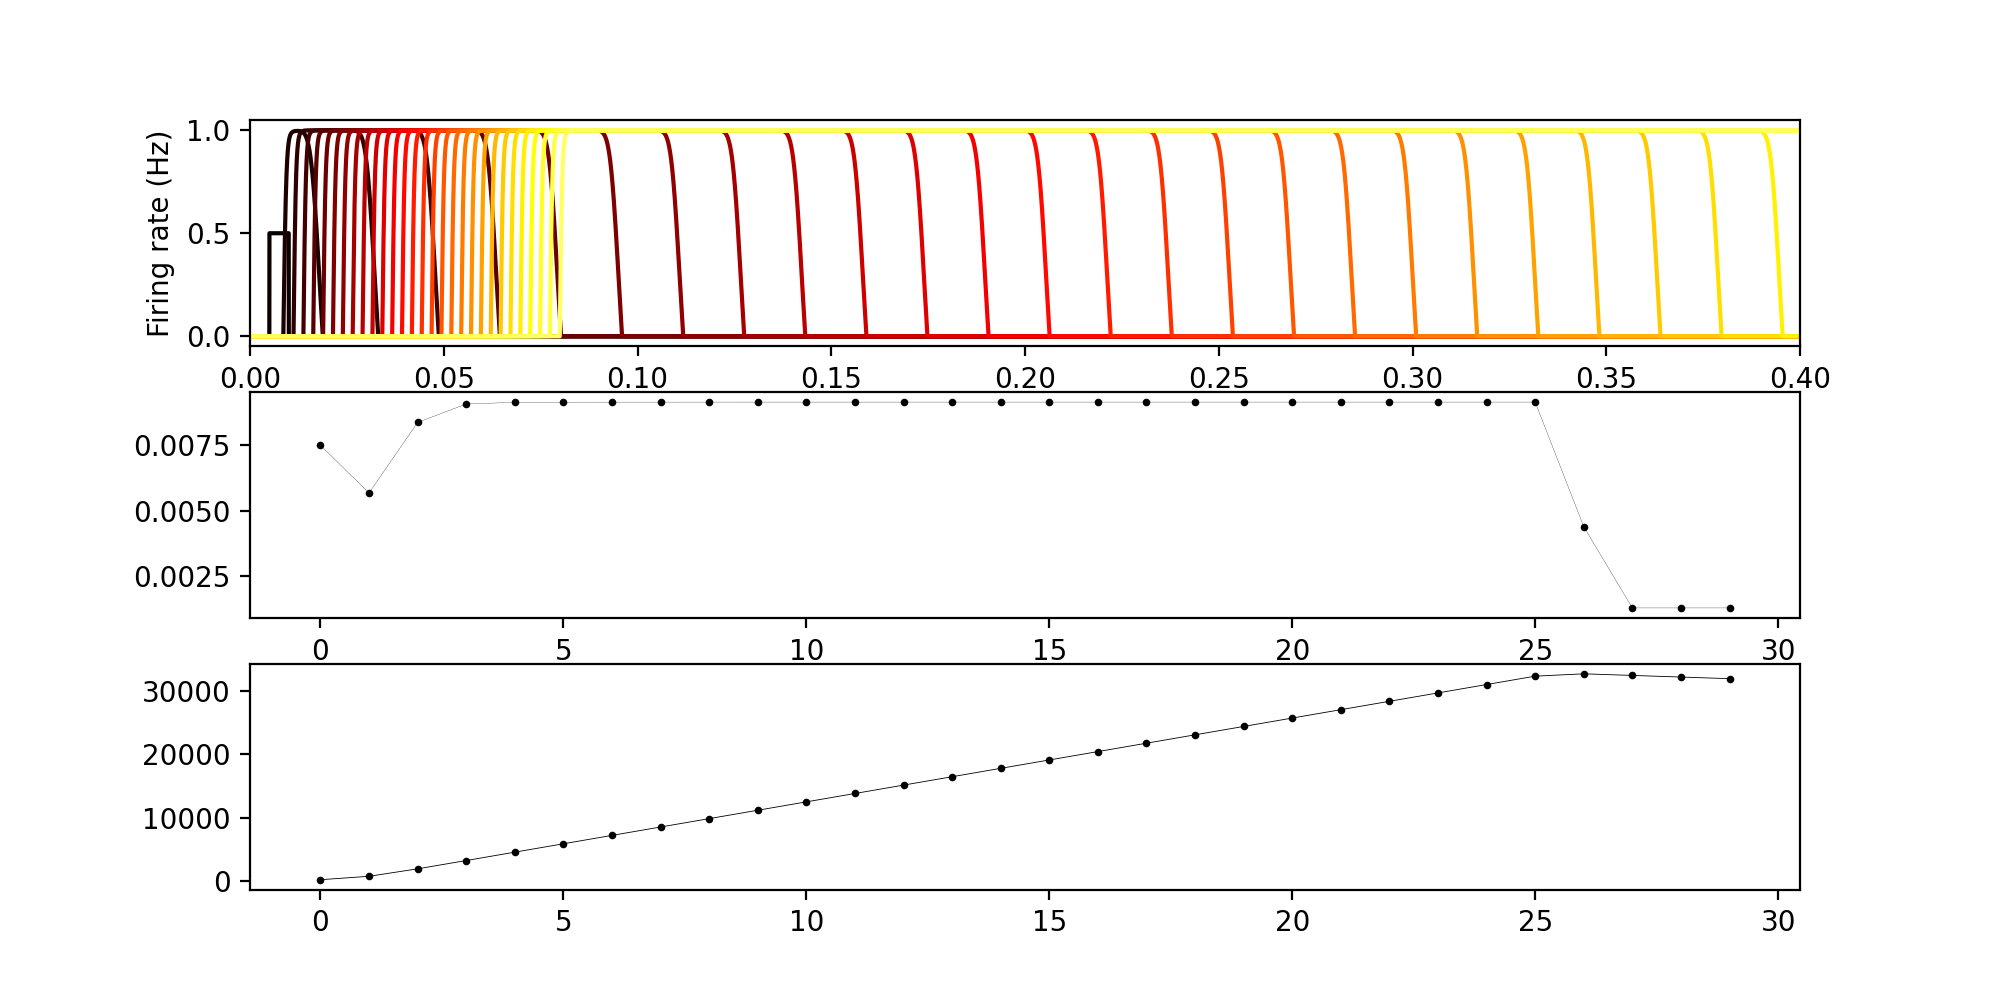

Text(0, 0.5, 'Firing rate (Hz)')

In [22]:
scale = 1
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10 * scale, 5 * scale))

T = 0.4
dt = 1e-5
t = np.linspace(0, T, int(T / dt))

# r_in = generate_gaussian_pulse(t, 0.01, 0.002, w=0.5)

r_in = np.where(np.logical_and(t > 0.005, t < 0.01), 0.5, 0)

colors = get_ordered_colors('hot', 70)

r, s = simulate(t, 60, r_in, w=1e-4 / dt, dt=dt, v_th=1.5, w_r=0)

all_mean_times = []
all_total_activities = []

for i in range(r.shape[1]):
    if i % 2 == 0:
        axs[0].plot(t, r[:, i], c=colors[i])
        r_summed = np.sum(r[:, i])
        all_mean_times.append(np.dot(r[:, i], t) / r_summed)
        all_total_activities.append(r_summed)
        
def shift(x):
    shifted = np.concatenate([[0], copy(x[:-1])])
    return shifted
                            
x = np.arange(len(all_mean_times))
axs[1].scatter(x, all_mean_times - shift(all_mean_times), c='black', s=3)
axs[1].plot(x, all_mean_times - shift(all_mean_times), c='black', lw=0.1)
axs[2].scatter(x, all_total_activities, c='black', s=3)
axs[2].plot(x, all_total_activities, c='black', lw=0.3)

    
axs[0].set_xlim(0, T)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Firing rate (Hz)')

<IPython.core.display.Javascript object>


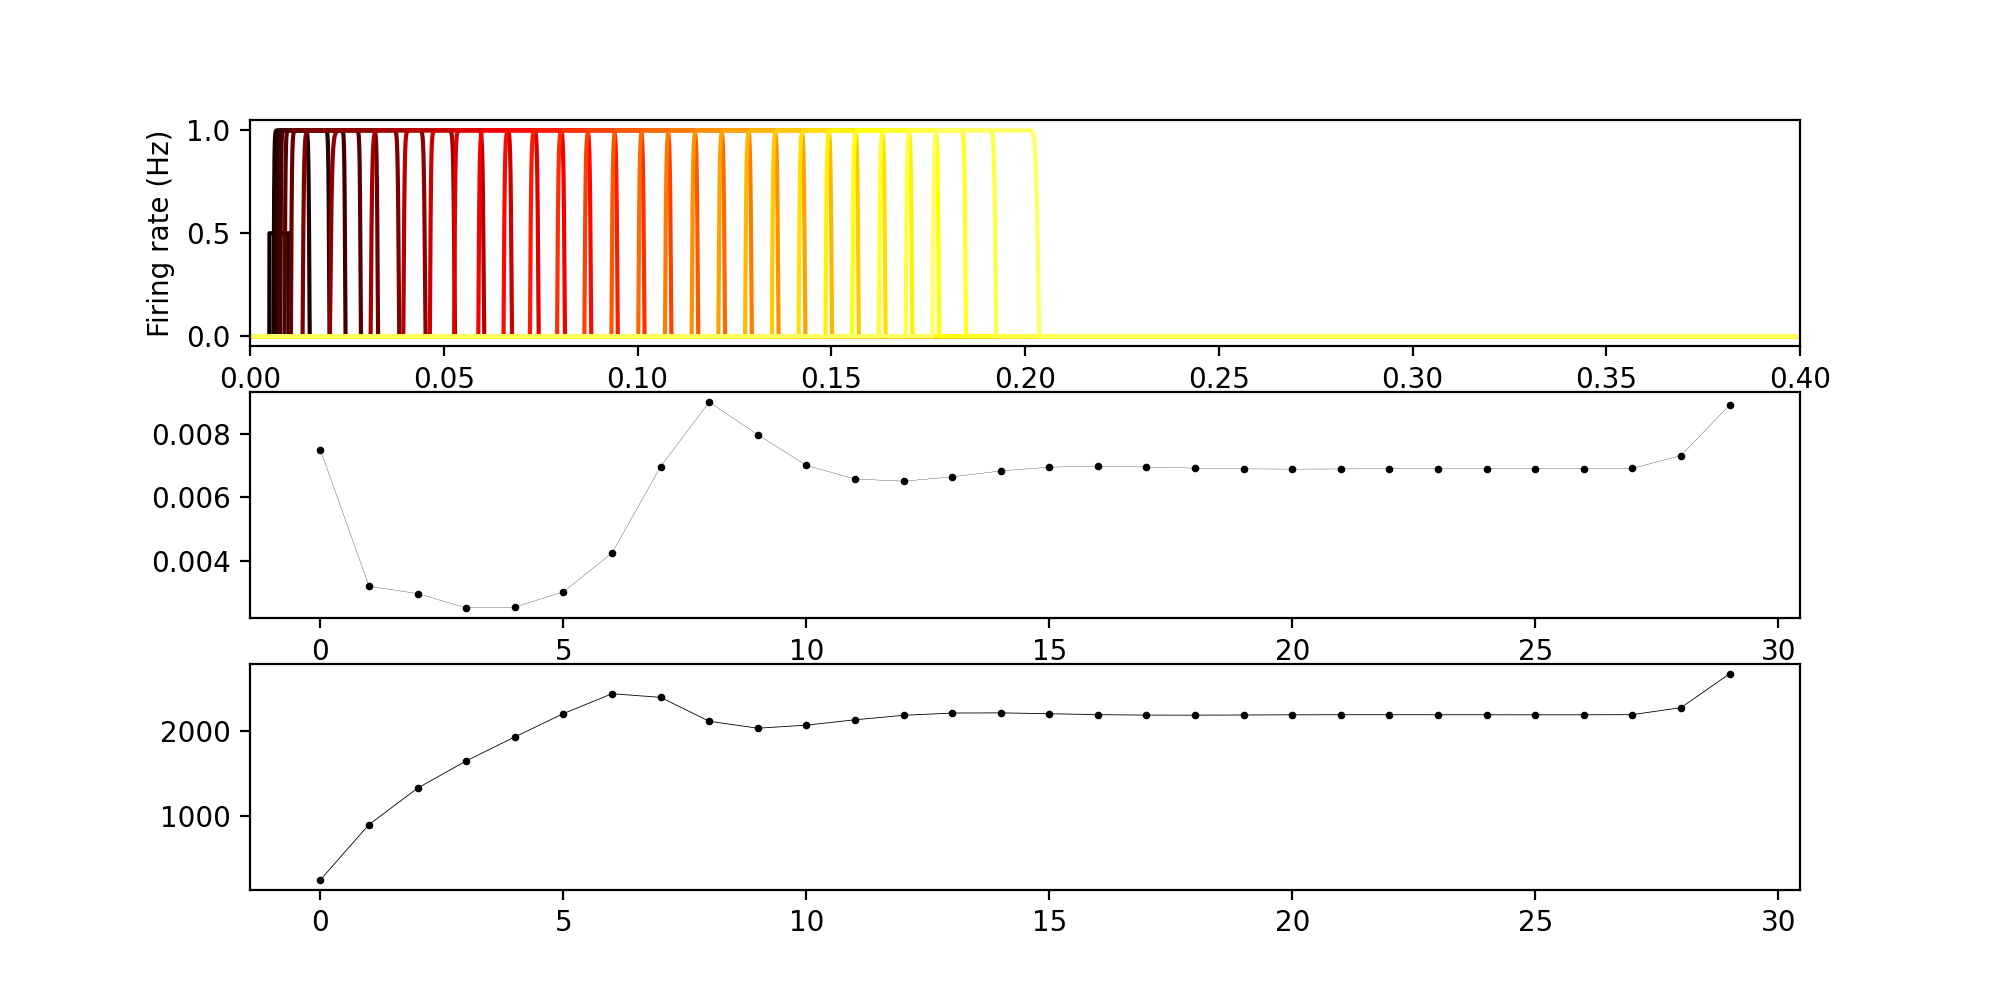

Text(0, 0.5, 'Firing rate (Hz)')

In [33]:
scale = 1
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10 * scale, 5 * scale))

T = 0.4
dt = 1e-5
t = np.linspace(0, T, int(T / dt))

# r_in = generate_gaussian_pulse(t, 0.01, 0.002, w=0.5)

r_in = np.where(np.logical_and(t > 0.005, t < 0.01), 0.5, 0)

colors = get_ordered_colors('hot', 70)

r, s = simulate(t, 60, r_in, w=3e-4 / dt, dt=dt, v_th=1.5, w_r=-2e-5 / dt)

all_mean_times = []
all_total_activities = []

for i in range(r.shape[1]):
    if i % 2 == 0:
        axs[0].plot(t, r[:, i], c=colors[i])
        r_summed = np.sum(r[:, i])
        all_mean_times.append(np.dot(r[:, i], t) / r_summed)
        all_total_activities.append(r_summed)
        
def shift(x):
    shifted = np.concatenate([[0], copy(x[:-1])])
    return shifted
                            
x = np.arange(len(all_mean_times))
axs[1].scatter(x, all_mean_times - shift(all_mean_times), c='black', s=3)
axs[1].plot(x, all_mean_times - shift(all_mean_times), c='black', lw=0.1)
axs[2].scatter(x, all_total_activities, c='black', s=3)
axs[2].plot(x, all_total_activities, c='black', lw=0.3)

    
axs[0].set_xlim(0, T)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Firing rate (Hz)')

<IPython.core.display.Javascript object>


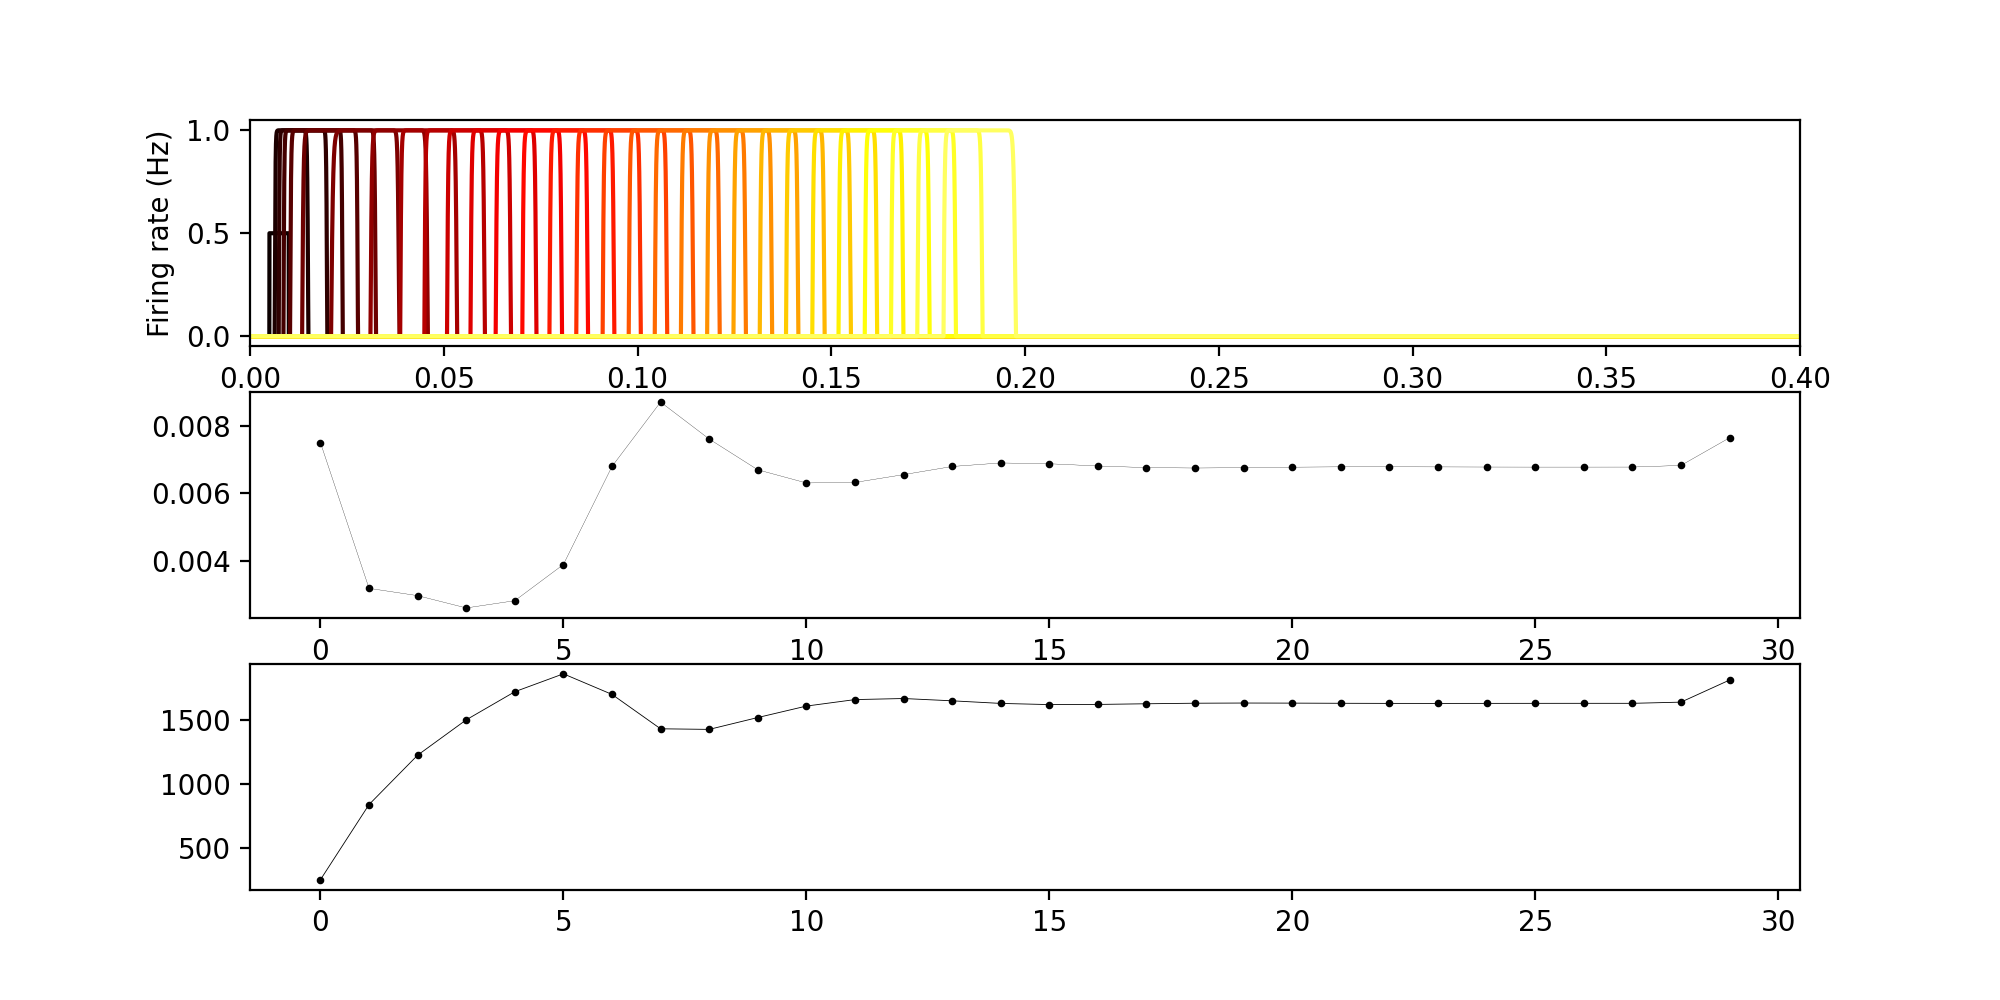

Text(0, 0.5, 'Firing rate (Hz)')

In [62]:
scale = 1
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10 * scale, 5 * scale))

T = 0.4
dt = 1e-5
t = np.linspace(0, T, int(T / dt))

# r_in = generate_gaussian_pulse(t, 0.01, 0.002, w=0.5)

r_in = np.where(np.logical_and(t > 0.005, t < 0.01), 0.5, 0)

colors = get_ordered_colors('hot', 70)

r, s = simulate(t, 60, r_in, w=6000 * dt, dt=dt, v_th=2, w_r=-1 * dt)

all_mean_times = []
all_total_activities = []

for i in range(r.shape[1]):
    if i % 2 == 0:
        axs[0].plot(t, r[:, i], c=colors[i])
        r_summed = np.sum(r[:, i])
        all_mean_times.append(np.dot(r[:, i], t) / r_summed)
        all_total_activities.append(r_summed)
        
def shift(x):
    shifted = np.concatenate([[0], copy(x[:-1])])
    return shifted
                            
x = np.arange(len(all_mean_times))
axs[1].scatter(x, all_mean_times - shift(all_mean_times), c='black', s=3)
axs[1].plot(x, all_mean_times - shift(all_mean_times), c='black', lw=0.1)
axs[2].scatter(x, all_total_activities, c='black', s=3)
axs[2].plot(x, all_total_activities, c='black', lw=0.3)

    
axs[0].set_xlim(0, T)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Firing rate (Hz)')

In [ ]:
params = 

In [18]:
def calc_out(t_1, t_2, a, params):
    p = params
    t_b = t_2 - t_1
    
    offset = p['tau_e'] * p['w_r'] * t_b / t_1
    offset = 0
    
    t_1_out = -p['tau_e'] * np.log(1 - (p['v_th'] - offset)  / (p['w_ee'] * p['tau_e'] * a))
    t_2_out = -p['tau_e'] * np.log((p['v_th'] - offset) / (p['w_ee'] * p['tau_e'] * a * (np.exp(t_b / p['tau_e']) - 1)))
    a_out = np.tanh(p['w_ee'] * p['tau_e'] * a * (1 - np.exp(-t_b / p['tau_e'])) - p['tau_e'] * p['v_th'] + offset)
    return t_1_out, t_2_out, a_out

In [19]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.1,
    'w_r': 0,
    'w_ee': 300,
}

cmap = cm.YlOrRd

normalize = matplotlib.colors.Normalize()

t_2_in, a_in = np.meshgrid(np.linspace(0, 20e-3, 20), np.linspace(0, 1, 20))

t_1_out, t_2_out, a_out = calc_out(0, t_2_in, a_in, params)

prop_speeds = 1 / t_1_out
prop_speeds[np.isnan(prop_speeds)] = 0

t_b_out = t_2_out - t_1_out

norms = np.sqrt(np.square(t_b_out - t_2_in) + np.square(a_out - a_in))

plt.quiver(t_b_in, a_in, (t_b_out - t_2_in) / norms, (a_out - a_in) / norms, color=cmap(prop_speeds / prop_speeds.max()).reshape(400, 4))
plt.xlabel('Burst duration (s)')
plt.ylabel('Input amplitude')
plt.show()

NameError: name 't_b_in' is not defined

In [15]:
def calc_out(t_1, t_2, a, params):
    p = params
    t_b = t_2 - t_1
    
    offset = p['tau_e'] * p['w_r'] * t_b / t_1
    
    t_1_out = -p['tau_e'] * np.log(1 - (p['v_th'] - offset)  / (p['w_ee'] * p['tau_e'] * a))
    t_2_out = -p['tau_e'] * np.log((p['v_th'] - offset) / (p['w_ee'] * p['tau_e'] * a * (np.exp(t_b / p['tau_e']) - 1)))
    a_out = np.tanh(p['w_ee'] * p['tau_e'] * a * (1 - np.exp(-t_b / p['tau_e'])) - p['v_th'] + offset)
    return t_1_out, t_2_out, a_out

<IPython.core.display.Javascript object>


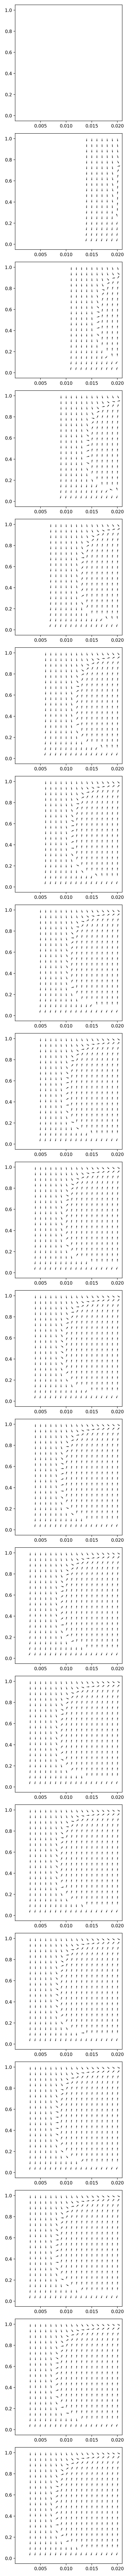

In [43]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.1,
    'w_r': 0,
    'w_ee': 300,
}

cmap = cm.viridis

normalize = matplotlib.colors.Normalize()

prop_in, t_b_in, a_in = np.meshgrid(np.linspace(50, 500, 20), np.linspace(1e-3, 20e-3, 20), np.linspace(0, 1, 20))
t_1_in = 1/prop_in

t_1_out, t_2_out, a_out = calc_out(t_1_in, t_b_in, a_in, params)
t_b_out = t_2_out - t_1_out

prop_speeds = 1 / t_1_out
prop_speeds[np.isnan(prop_speeds)] = 0

norms = np.sqrt(np.square((t_b_out - t_b_in)) + np.square(a_out - a_in))

scale = 4
gs = gridspec.GridSpec(20, 1)
fig = plt.figure(figsize=(scale, scale * 20), tight_layout=True)
axs = [fig.add_subplot(gs[i]) for i in range(20)]

t_b_diffs = (t_b_out - t_b_in)/norms
a_diffs = (a_out - a_in)/norms

for i in range(20):
    axs[i].quiver(t_b_in[:, i, :], a_in[:, i, :], t_b_diffs[:, i, :], a_diffs[:, i, :])

<IPython.core.display.Javascript object>


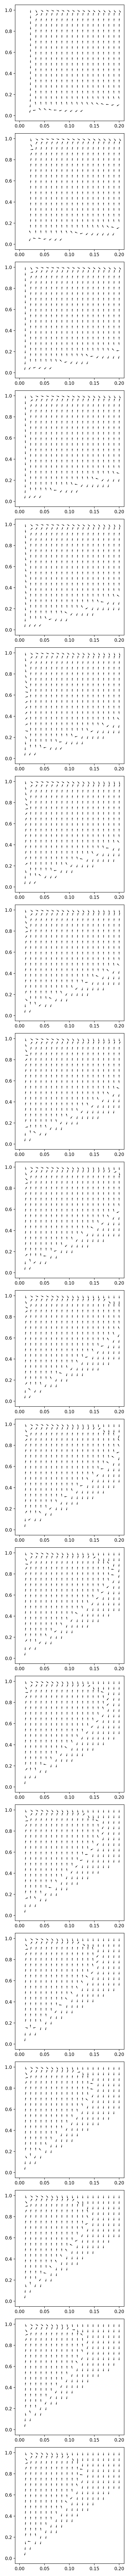

In [39]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.05,
    'w_r': -2,
    'w_ee': 300,
}

cmap = cm.viridis

normalize = matplotlib.colors.Normalize()

prop_in, t_b_in, a_in = np.meshgrid(np.linspace(50, 500, 20), np.linspace(1e-3, 200e-3, 20), np.linspace(0, 1, 20))
t_1_in = 1/prop_in

t_1_out, t_2_out, a_out = calc_out(t_1_in, t_b_in, a_in, params)
t_b_out = t_2_out - t_1_out

prop_speeds = 1 / t_1_out
prop_speeds[np.isnan(prop_speeds)] = 0

norms = np.sqrt(np.square((t_b_out - t_b_in)) + np.square(a_out - a_in))

scale = 4
gs = gridspec.GridSpec(20, 1)
fig = plt.figure(figsize=(scale, scale * 20), tight_layout=True)
axs = [fig.add_subplot(gs[i]) for i in range(20)]

t_b_diffs = (t_b_out - t_b_in)/norms
a_diffs = (a_out - a_in)/norms

for i in range(20):
    axs[i].quiver(t_b_in[:, i, :], a_in[:, i, :], t_b_diffs[:, i, :], a_diffs[:, i, :])

# ax.quiver(prop_in, t_b_in, a_in, (1/t_1_out - prop_in)/norms,
#            (t_b_out - t_b_in)/norms, (a_out - a_in)/norms,
#            length=50., arrow_length_ratio=0.001)
# ax.set_xlabel('Propagation speed (Hz)')
# ax.set_ylabel('Burst duration (s)')
# ax.set_zlabel('Input amplitude')
# plt.xlabel('Burst delay (s)')
# plt.ylabel('Burst duration (s)')
# plt.zlabel('Input amplitude')

<IPython.core.display.Javascript object>


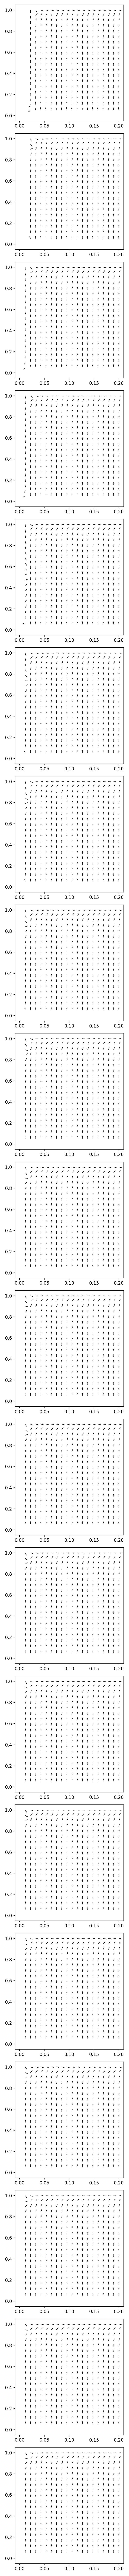

In [20]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.05,
    'w_r': -3,
    'w_ee': 300,
}

cmap = cm.viridis

normalize = matplotlib.colors.Normalize()

prop_in, t_b_in, a_in = np.meshgrid(np.linspace(50, 500, 20), np.linspace(1e-3, 200e-3, 20), np.linspace(0, 1, 20))
t_1_in = 1/prop_in

t_1_out, t_2_out, a_out = calc_out(t_1_in, t_b_in, a_in, params)
t_b_out = t_2_out - t_1_out

prop_speeds = 1 / t_1_out
prop_speeds[np.isnan(prop_speeds)] = 0

norms = np.sqrt(np.square((t_b_out - t_b_in)) + np.square(a_out - a_in))

scale = 4
gs = gridspec.GridSpec(20, 1)
fig = plt.figure(figsize=(scale, scale * 20), tight_layout=True)
axs = [fig.add_subplot(gs[i]) for i in range(20)]

t_b_diffs = (t_b_out - t_b_in)/norms
a_diffs = (a_out - a_in)/norms

for i in range(20):
    axs[i].quiver(t_b_in[:, i, :], a_in[:, i, :], t_b_diffs[:, i, :], a_diffs[:, i, :])

# ax.quiver(prop_in, t_b_in, a_in, (1/t_1_out - prop_in)/norms,
#            (t_b_out - t_b_in)/norms, (a_out - a_in)/norms,
#            length=50., arrow_length_ratio=0.001)
# ax.set_xlabel('Propagation speed (Hz)')
# ax.set_ylabel('Burst duration (s)')
# ax.set_zlabel('Input amplitude')
# plt.xlabel('Burst delay (s)')
# plt.ylabel('Burst duration (s)')
# plt.zlabel('Input amplitude')

<IPython.core.display.Javascript object>


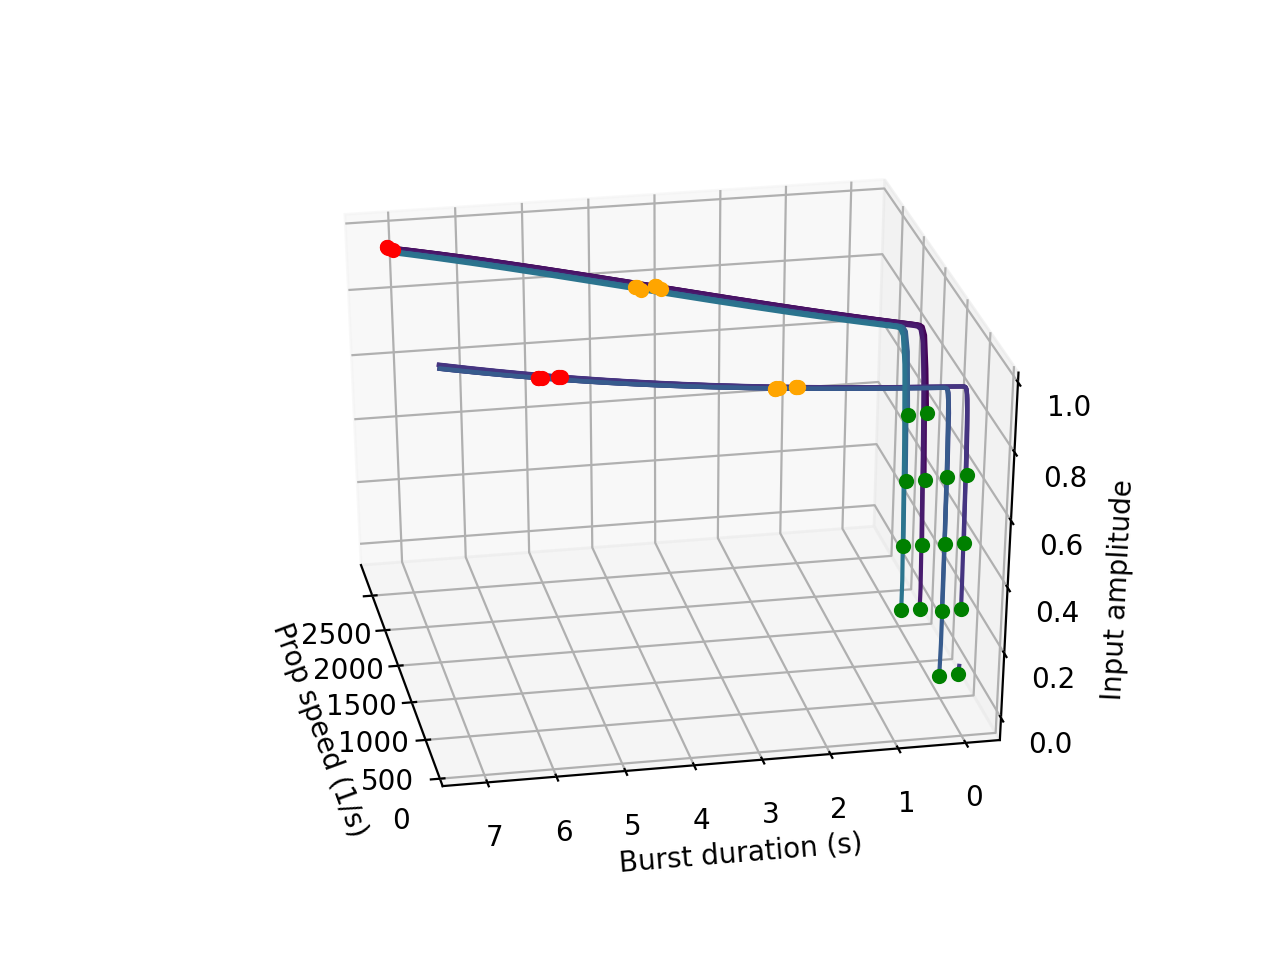

Text(0.5, 0, 'Input amplitude')

In [21]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.05,
    'w_r': -2,
    'w_ee': 200,
}

def generate_traj(t_1_in, t_b_in, a_in, params, n_iters=10):
    t_1 = [t_1_in]
    t_b = [t_b_in]
    a = [a_in]
    
    for i in range(n_iters):
        t_1_out, t_2_out, a_out = calc_out(t_1[-1], t_b[-1], a[-1], params)
        
        t_1_out = t_1[-1] + 0.01 * (t_1_out - t_1[-1])    
        t_b_out = t_2_out - t_1_out
#         t_1_out = np.max([0, t_1_out])
        t_b_out = np.max([0, t_b_out])
        a_out = np.max([0, a_out])
        
#         print(t_1_out, t_b_out, a_out)
        t_1.append(t_1_out)
        t_b.append(t_b_out)
        a.append(a_out)
    
    return t_1, t_b, a


norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(a_out - a_in) + np.square(t_1_out - t_1_in))

fig = plt.figure()
ax = fig.gca(projection='3d')

colors = get_ordered_colors('viridis', 40)

inputs = [
    (1e-3, 20e-3, 0.7),
    (1e-3, 20e-3, 0.5),
    (1e-3, 20e-3, 0.3),
    (1e-3, 20e-3, 0.1),
    (10e-3, 20e-3, 0.7),
    (10e-3, 20e-3, 0.5),
    (10e-3, 20e-3, 0.3),
    (10e-3, 20e-3, 0.1),
    (10e-3, 300e-3, 0.7),
    (10e-3, 300e-3, 0.5),
    (10e-3, 300e-3, 0.3),
    (10e-3, 300e-3, 0.1),
    (1e-3, 300e-3, 0.7),
    (1e-3, 300e-3, 0.5),
    (1e-3, 300e-3, 0.3),
    (1e-3, 300e-3, 0.1),
#     (1e-3, 10e-3, 0.7),
#     (1e-3, 5e-3, 0.7),
#     (1e-3, 1.5e-3, 0.7),
#     (1e-3, 20e-3, 0.2),
#     (1e-3, 10e-3, 0.2),
#     (1e-3, 5e-3, 0.2),
]

for k, inp in enumerate(inputs):
    (t_1, t_2, a) = generate_traj(inp[0], inp[1], inp[2], params, n_iters=400)
    ax.plot(1/np.array(t_1), t_2, a, c=colors[k])
    ax.scatter(1/t_1[0], t_2[0], a[0], color='green')
    ax.scatter(1/t_1[-100], t_2[-100], a[-100], color='red')
    ax.scatter(1/t_1[-200], t_2[-200], a[-200], color='red')
    ax.scatter(1/t_1[-300], t_2[-300], a[-300], color='orange')

ax.set_xlabel('Prop speed (1/s)')
ax.set_ylabel('Burst duration (s)')
ax.set_zlabel('Input amplitude')
# plt.xlabel('Burst delay (s)')
# plt.ylabel('Burst duration (s)')
# plt.zlabel('Input amplitude')

<IPython.core.display.Javascript object>


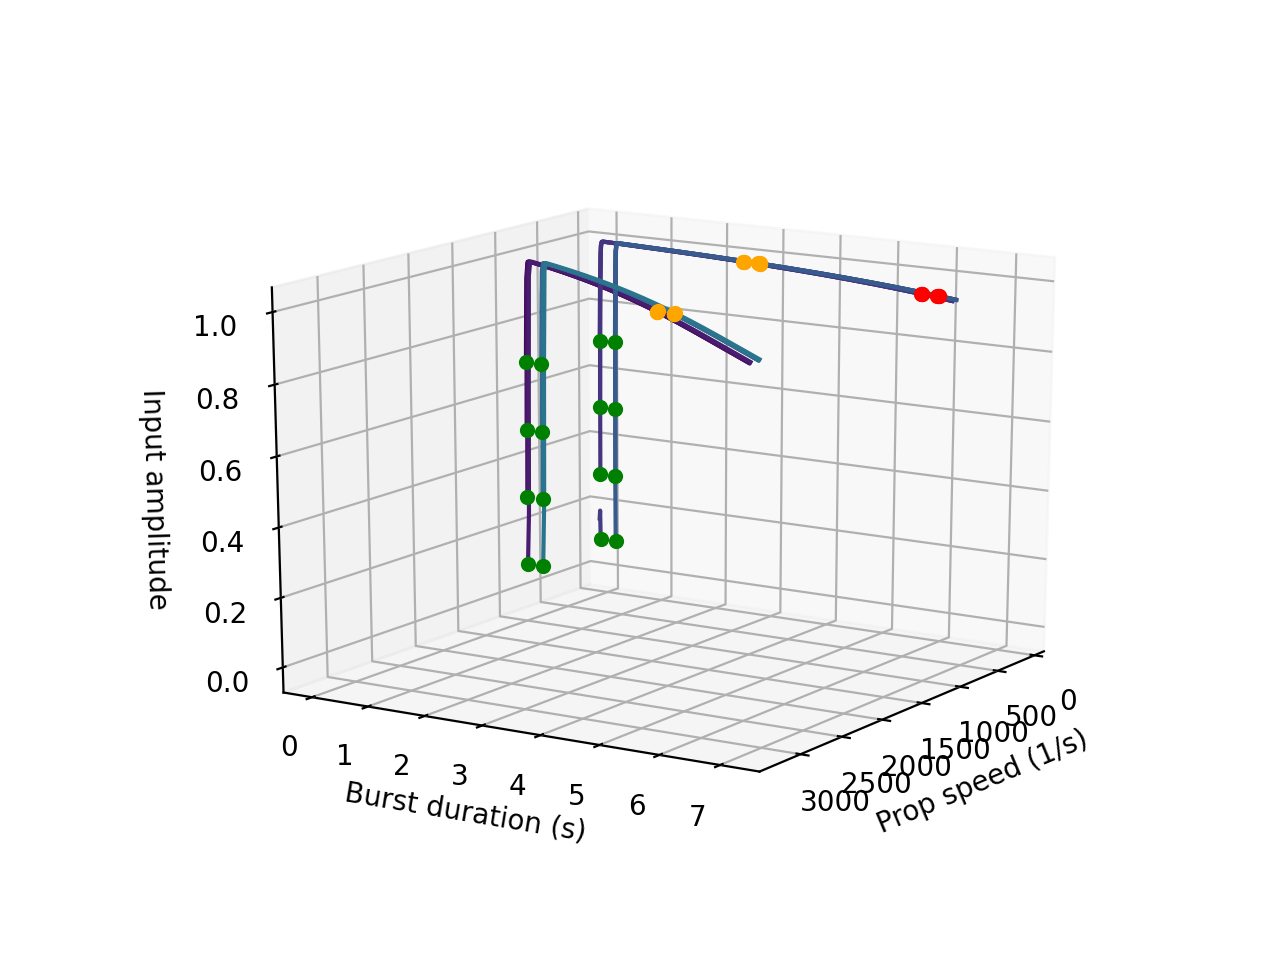

Text(0.5, 0, 'Input amplitude')

In [22]:
params = {
    'tau_e': 10e-3,
    'v_th': 0.05,
    'w_r': -2,
    'w_ee': 300,
}

def generate_traj(t_1_in, t_b_in, a_in, params, n_iters=10):
    t_1 = [t_1_in]
    t_b = [t_b_in]
    a = [a_in]
    
    for i in range(n_iters):
        t_1_out, t_2_out, a_out = calc_out(t_1[-1], t_b[-1], a[-1], params)
        
        t_1_out = t_1[-1] + 0.01 * (t_1_out - t_1[-1])    
        t_b_out = t_2_out - t_1_out
#         t_1_out = np.max([0, t_1_out])
        t_b_out = np.max([0, t_b_out])
        a_out = np.max([0, a_out])
        
#         print(t_1_out, t_b_out, a_out)
        t_1.append(t_1_out)
        t_b.append(t_b_out)
        a.append(a_out)
    
    return t_1, t_b, a


norms = np.sqrt(np.square(t_b_out - t_b_in) + np.square(a_out - a_in) + np.square(t_1_out - t_1_in))

fig = plt.figure()
ax = fig.gca(projection='3d')

colors = get_ordered_colors('viridis', 40)

inputs = [
    (1e-3, 20e-3, 0.7),
    (1e-3, 20e-3, 0.5),
    (1e-3, 20e-3, 0.3),
    (1e-3, 20e-3, 0.1),
    (10e-3, 20e-3, 0.7),
    (10e-3, 20e-3, 0.5),
    (10e-3, 20e-3, 0.3),
    (10e-3, 20e-3, 0.1),
    (10e-3, 300e-3, 0.7),
    (10e-3, 300e-3, 0.5),
    (10e-3, 300e-3, 0.3),
    (10e-3, 300e-3, 0.1),
    (1e-3, 300e-3, 0.7),
    (1e-3, 300e-3, 0.5),
    (1e-3, 300e-3, 0.3),
    (1e-3, 300e-3, 0.1),
#     (1e-3, 10e-3, 0.7),
#     (1e-3, 5e-3, 0.7),
#     (1e-3, 1.5e-3, 0.7),
#     (1e-3, 20e-3, 0.2),
#     (1e-3, 10e-3, 0.2),
#     (1e-3, 5e-3, 0.2),
]

for k, inp in enumerate(inputs):
    (t_1, t_2, a) = generate_traj(inp[0], inp[1], inp[2], params, n_iters=400)
    ax.plot(1/np.array(t_1), t_2, a, c=colors[k])
    ax.scatter(1/t_1[0], t_2[0], a[0], color='green')
    ax.scatter(1/t_1[-100], t_2[-100], a[-100], color='red')
    ax.scatter(1/t_1[-200], t_2[-200], a[-200], color='red')
    ax.scatter(1/t_1[-300], t_2[-300], a[-300], color='orange')

ax.set_xlabel('Prop speed (1/s)')
ax.set_ylabel('Burst duration (s)')
ax.set_zlabel('Input amplitude')
# plt.xlabel('Burst delay (s)')
# plt.ylabel('Burst duration (s)')
# plt.zlabel('Input amplitude')